# A demonstration of PANDAS data frames used to investigate CAO points

Author: Jon Ishaque
Commenced: 29th September 2021
GMIT SID: G00398244

This notebook extracts CAO points from the CAO website for 2019, 2020 and 2021. It loads data into pandas dataframes and uses pandas and python to compare points from different years.

 Documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
 
 
*** 

In [2]:

#Package to make http requests
#(Requests: HTTP for Humans™ — Requests 2.26.0 documentation, 2021)
import requests as rq 

# Dates and time package (installed with python)
import datetime as dt

#pandas to load data into dataframes and use functionality to manipulate data and analyse data
import pandas as pd

#import regex package for searching strings (installed with python)
#(re — Regular expression operations — Python 3.10.0 documentation, 2021)
import re 

#import csv, deals with commas when writing to file
import csv

#use urlib to retrieve url as file for 2019 and 2020   (installed with python)
import urllib.request as urlrq 

#Python plotting package
import matplotlib.pyplot as plt 

#camelot pdf file reader package
import camelot



***
## 1. Loading CAO data into pandas.

Loading data into the notebook and pandas dataframes requires 3 different methods for each of the years 2019, 2020 and 2021 because for each year the data is in a different format:

2021 html webpage format

2020 Microsoft Excel format

2019 pdf

The next state of the notebook will explain how each years CAO points are accessed from the CAO website, backed up locally in their original format and imported into a pandas dataframe for each year either directly or from a saved csv..

The dataframes for each year are then joined up (1.4).



*** 
### 1.1 2021 points

#http://www.cao.ie/index.php?page=points&p=2021

The 2021 CAO points are presented in a web page. 
There are two pages one for level 6 & 7 and one for level 8.
The web page are saved and files and loaded into a dataframe. 

The function get2021() 
reads a webpage  accessed using the request library.
Each line of the web page is read and tested for CAO course and points line
with a regex. There are helper functions atomise fields into characters which may indicate, random selections and portfolio/interview assessment for courses. There is also a function to determing the institution form the course code. Each line is then written to a csv file.

Both the level 6 & 7 and level 8 are then loaded into a single dataframe df2021

The page header from the server should decode as per: *Content-Type: text/html; charset=iso-8859-1*
However, one line uses \x96 which isn't defined in iso-8859-1. Therefore we use the similar decoding standard cp1252, which is very similar but includes #x96. The character in question was had an Irish foda on a level 8 course

In [3]:
# Get the current date and time.
#Create a string var,*now*. this is use in file names of back up copies of CAO points.
now = dt.datetime.now()

# Format as a string.
#global as used in functions
global nowstr
nowstr = now.strftime('%Y%m%d_%H%M%S')



Compile the regular expression so it is not compiled at each interation of the loop reading the webpage

Explanation of the regualar expression (re — Regular expression operations — Python 3.10.1 documentation, 2021):

**('&#91;A-Z]{2}&#91;0-9&#93;{3} (.*)(&#91;0-9&#93;{3})')**


&#91;A-Z&#93;{2}           Any two upper case aphanumeric

&#91;0-9&#93;{3}           Any three digits 0-9

'  '                       Two spaces

(.*)(&#91;0-9&#93;{3})     Any amount of text before 3 numeric characters




In [4]:
#set reg ex
re_courses = re.compile('[A-Z]{2}[0-9]{3} (.*)') 
#(re — Regular expression operations — Python 3.10.1 documentation, 2021)

In [11]:
#Function to get HEI name from course code. using a switcher dict as
#oppose to messy if/else block
#(How to Implement Switch Case Functions in Python? [2021] | upGrad blog, 2021)
def getHEI(cc):
    switcher = {'AC' : 'American College',
    'AD' : 'National College of Art and Design',
    'AL' : 'Athlone Institute of Technology',
    'AS' : 'St. Angela`s College',
    'CI' : 'Irish College of Humanities & Applied Sciences',
    'BY' : 'IBAT College Dublin',
    'BN' : 'Technological University Dublin Blanchardstown Campus',

    'CK' : 'University College Cork (NUI)',
    'CM' : 'Marino Institute of Education',
    'CR' : 'Cork Institute of Technology',
    'CT' : 'CCT College Dublin',
    'CW' : 'Institute of Technology Carlow',
    'DB' : 'Dublin Business School',
    'DC' : 'Dublin City University',
    'DK' : 'Dundalk Institute of Technology',
    'DL' : 'Dun Laoghaire Institute of Art Design and Technology',
    'DT' : 'Technological University Dublin City Campus',
    'TA' : 'Technological University Dublin Tallaght Campus',
    'DN' : 'University College Dublin (NUI)',
    'DS' : 'Dorset College',
    'GA' : 'Galway-Mayo Institute of Technology',
    'GB' : 'Galway Business School',
    'GC' : 'Griffith College',
    'GY' : 'National University of Ireland Galway',
    'ID' : 'ICD Business School',
    'LC' : 'Limerick Institute of Technology',
    'LM' : 'University of Limerick',
    'LY' : 'Letterkenny Institute of Technology',
    'MH' : 'Maynooth University',
    'MI' : 'Mary Immaculate College',
    'MU' : 'Pontifical University St Patricks College',
    'NC' : 'National College of Ireland (NCI)',
    'NM' : 'St Nicholas Montessori College Ireland',
    'PC' : 'Carlow College St. Patricks',
    'RC' : 'RCSI University of Medicine & Health Sciences',
    'SG' : 'Institute of Technology Sligo',
    'TL' : 'Institute of Technology Tralee',
    'TR' : 'Trinity College Dublin',
    'TU' : 'Technological University Dublin',
    'WD' : 'Waterford Institute of Technology'
    }
    cc = cc[:2]
    return  switcher.get(cc)


In [12]:
#helper function to AQA,* and # indicators from points values
def points_to_arr(s):
    AQA=''
    portfolio =''
    points=''
    random = ''
    #check 1st char for #
    #print(s)
    if s[0]=='#':
        portfolio='#'# add to var
    #check final char for  *
    if s[-1] == '*':
        random ='*'
    points=''    
    if s.find('AQA') ==-1: #not AQA
        #strip ~ and * from start and end of s
        for i in s:
            if i.isdigit():
                #concat points string
                points = points + i
    else:
        AQA ="AQA" #return AQA as separate val as it will be separate column
        #return
    return [points, portfolio, random,AQA]

This part of the note part of the note book will load the web page content. A loop will read each line of web page and determine if it's content is relevant and write content to a csv file.

In [13]:
#global csv path list so the programme
#will find the csv files after function
global csv_files
csv_files = []
def get2021(path): #A function to create csv files from both the L6&7 and L8 webpages.
    #Get the both level 8 and 6/7 web pages
    #getheaders and determine contenttype
    #loop through response text lines
    #get level
    #print (path)
    if path.find('L8') >= 0 :
        level = '8'
        resp = rq.get('http://www2.cao.ie/points/l8.php',
                      headers={"content-type":"text"})
    elif path.find('L67') >= 0 :
        level ='6/7'        
        resp = rq.get('http://www2.cao.ie/points/l76.php', 
                      headers={"content-type":"text"})
    else:
        level = ''        
    original_encoding = resp.encoding
    # Change to cp1252, which handles accented characters
    resp.encoding = 'cp1252'
    # Create a file path for the original data. 2021
    pathhtml = path + nowstr + '.html'
    # Save the original html file.
    with open(pathhtml, 'w') as f:
        f.write(resp.text)
    #set var to count lines for cross check with webpage
    no_lines = 0
    path = path+'.csv'
    #add csv name to array so as to access when loading into df
    csv_files.append(path)
    with open(path, 'w') as f:
        #write csv header
        '''
        PREFIXES:
        R1 = Round 1 points
        *     Not all on this points score were offered places.
        #     Test / Interview / Portfolio / Audition
        AQA   All qualified applicants
        '''
        
        
        linesplit = ['Course Code','Course title','R1',
                     'Po1','Rn1','AQA1','R2',
                     'Po2','Rn2','AQA2',
                     'HEI','Level','Year']
        f.write(','.join(linesplit) + '\n')
        #loop through each line of csv and do something.
        for line in resp.iter_lines():
            #problem with bytes so convert str to bytes
            dline = line.decode('cp1252')
            #check if line mathces reg exp pattern. If so, do something.
            if re_courses.fullmatch(dline):
                no_lines +=1
                #get first five chars - course code
                course_code = dline[:5]
                
                #course title
                course_title = dline[7:57]
                #r1 points
                round_1 = dline[60:65].rstrip() # get five chars, remove white space
                #if round 1 not blank call fn points_to_arr
                if len(round_1) > 0:
                   
                    round_1= points_to_arr(round_1)
                    #assign vals from returned array
                    pts1 = round_1[0]
                    plo1 = round_1[1]
                    rnd1 = round_1[2]
                    AQA1 = round_1[3]
                else: 
                    pts1 = ''
                    plo1 = ''
                    rnd1 = ''
                    AQA1 = ''
                #r2 points
                round_2 = dline[67:].rstrip() # get four chars, remove white space
                #if round 2 not blank call fn points_to_arr
                if len(round_2) > 0:
                    round_2= points_to_arr(round_2)
                    #assign vals from returned array
                    pts2 = round_2[0]
                    plo2 = round_2[1]
                    rnd2 = round_2[2]
                    AQA2 = round_2[3]
                else: 
                    pts2 = ''
                    plo2 = ''
                    rnd2 = ''
                    AQA2 = ''
                #print (course_code)
                #get the instituion name
                HEI =getHEI(course_code)
                #print (HEI)
                # create an array of the fields for the csv line
                linesplit = [course_code,course_title,pts1,plo1,rnd1,AQA2,pts2,plo2,rnd2,AQA2,HEI,level,'2021']
                #print (linesplit)
                #debug
                #print(f"'{course_code} {dline} r1: {round_1} r2: {round_2}'")
                # print((','.join(linesplit) + '\n'))
                # Rejoin the array values with commas in between. ie.comma separated
                f.write(','.join(linesplit) + '\n')
    print (f"{path}number of lines is ", {no_lines}) #print file path and number of lines as confirmation
    path=''



In [14]:
# The file path for the csv file.
path_2021_L8 = 'data/cao2021_L8_' + nowstr 
path_2021L67 ='data/cao2021_L67_' + nowstr 

#call the get2021 function with paths to save the html file and create a csv file

In [15]:
get2021(path_2021_L8)
get2021(path_2021L67)

data/cao2021_L8_20220102_110721.csvnumber of lines is  {949}
data/cao2021_L67_20220102_110721.csvnumber of lines is  {416}


NB: 949 L8 courses on CAO website verified on 10th November 2021

416 L6/7 courses on CAO website verified on 15th November 2021

Join L8 & L6/7 courses into one dataframe

In [16]:
# loop over the list of csv files (Pandas, 2021)
print(csv_files)
df2021 = pd.DataFrame()
for f in csv_files:      
    # read the csv file with correc encoding
    #print(f)
    df_temp = pd.read_csv(f,encoding='cp1252') 
    
    #create a dataframe with all 2021 data
    df2021 = df2021.append(df_temp, ignore_index = True)

#debug
#print(df2021)
df2021.to_csv('data/2021.csv')
    

['data/cao2021_L8_20220102_110721.csv', 'data/cao2021_L67_20220102_110721.csv']


*** 

### 1.2 2020 CAO points

http://www.cao.ie/index.php?page=points&p=2020 

The CAO points for 2020 stored in an excel(.xls) file. All level courses were indcluded in the one file
The excel file is downloaded using the urlrq package and backed up.
The file is read then downloaded into a  pandas data frame df2020.

Some unwanted columns are deleted and columns are renamed for consistency with other years.
*, AQA and # indicators are pulled out using pandas functionality and written to new columns.
 

In [17]:
# Create a file path for the original data.For backup
path2020 = 'data/cao2020_' + nowstr + '.xlsx'

#download to path
urlrq.urlretrieve('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx',\
                  path2020)

('data/cao2020_20220102_110721.xlsx',
 <http.client.HTTPMessage at 0x1b9aee86b20>)

Read the Excel file into a pandas dataframe 

In [18]:
#download and parse the excel spreadsheet
#skip first 10 header rows
#(pandas.read_excel — pandas 1.3.4 documentation, 2021)
df2020=pd.read_excel('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx',\
                 skiprows=10)
#delete unwanted columns
df2020 = df2020.drop(['CATEGORY (i.e.ISCED description)','avp','v','Column1',\
              'Column2','Column3','Column4','Column5','Column6',\
              'Column7','Column8','Test/Interview #','EOS Random *'], 1)
#rename columns 
df2020 = df2020.rename(columns={'COURSE TITLE': 'Course title',\
                        'COURSE CODE2': 'Course Code',\
                        'R1 POINTS':'R1','R2 POINTS':'R2',\
                        'R1 Random *':'Rn1',\
                        'R2 Random*':'Rn2','LEVEL':'Level',\
                        'EOS':'EOS','EOS Mid-point':'Mid'})
#add some new columns so we will match our 2021 dataframe
df2020['Year'] =2020
df2020['Po1'] =''
df2020['Po2'] =''
df2020['AQA1'] =''
df2020['AQA2'] =''

#Pulling out AQA, # and  placing into own column.
#this dataset has either digits or #matric code for portfolio and AQA. Check for value,
#if it exists place in another column and set points col to blank.
#(Check For a Substring in a Pandas DataFrame Column, 2021)
df2020.loc[df2020['R1'].str.contains('#',na=False) ,'Po1'] = '#'  
#df2020.loc[df2020['R1'].str.contains('#',na=False) ,'Po1'] = '#' 
df2020.loc[df2020['R2'].str.contains('#',na=False) ,'Po2'] = '#' 
df2020.loc[df2020['R1'].str.contains('AQA',na=False) , 'AQA1'] = 'AQA' 
df2020.loc[df2020['R2'].str.contains('AQA',na=False) , 'AQA2'] = 'AQA' 
#set to blank data which are either not needed or have been processed above
df2020.loc[df2020['EOS'].str.contains('matric',na=False) , 'EOS'] = '' 
df2020.loc[df2020['Mid'].str.contains('matric',na=False) , 'Mid'] = '' 
df2020.loc[df2020['R1'].str.contains('matric',na=False) , 'R1'] = '' 
df2020.loc[df2020['R1'].str.contains('AQA',na=False) , 'R1'] = ''
df2020.loc[df2020['R2'].str.contains('matric',na=False) , 'R2'] = '' 
df2020.loc[df2020['R2'].str.contains('AQA',na=False) , 'R2'] = '' 

#Need to clean '#' from points
#convert to string to use replace function
df2020['R1'] = df2020['R1'].astype(str) #(pandas and Riley, 2021)
df2020['R1'] = df2020['R1'].map(lambda x: x.replace('#',''))
df2020['R1'] = df2020['R1'].map(lambda x: x.lstrip('nan'))#remove nan to convert back to number('int', 2021)
df2020['R1'] = pd.to_numeric(df2020['R1'], errors='coerce')#back to numeric
#and round 2 points
df2020['R2'] = df2020['R2'].astype(str) #(pandas and Riley, 2021)
df2020['R2'] = df2020['R2'].map(lambda x: x.replace('#',''))
df2020['R2'] = df2020['R2'].map(lambda x: x.lstrip('nan'))#remove nan to convert back to number('int', 2021)
df2020['R2'] = pd.to_numeric(df2020['R2'], errors='coerce')#back to numeric

#and EOS points
df2020['EOS'] = df2020['EOS'].astype(str) #(pandas and Riley, 2021)
df2020['EOS'] = df2020['EOS'].map(lambda x: x.replace('#',''))
df2020['EOS'] = df2020['EOS'].map(lambda x: x.lstrip('nan'))#remove nan to convert back to number('int', 2021)
df2020['EOS'] = pd.to_numeric(df2020['EOS'], errors='coerce')#back to numeric

#and Mid points
df2020['Mid'] = df2020['Mid'].astype(str) #(pandas and Riley, 2021)
df2020['Mid'] = df2020['Mid'].map(lambda x: x.replace('#',''))
df2020['Mid'] = df2020['Mid'].map(lambda x: x.lstrip('nan'))#remove nan to convert back to number('int', 2021)
df2020['Mid'] = pd.to_numeric(df2020['Mid'], errors='coerce')#back to numeric
#debug
#print(df2020['R2'].dtype)
df2020.to_csv('data/2020.csv')

***

### 1.3 2019 CAO points
http://www2.cao.ie/points/lvl8_19.pdf


2019 CAO points are saved in a pdf file and tables within that file.
Like 2021 L8 and Levels 6&7 are stored on two web pages (pdfs)
For each pdf files: 
- the pdf is backed up
- the file is opened in camelot and the contents of each pdf table is appened to a dataframe.
- Columns are renamed and year column is added as and AQA, * and # are dealt with.
- A regex function filters the dataframe to only hold courses.


In [19]:
import camelot #use camelot package to extract tables from pdf files [7]

Read tables functions Parameters: url_path for path to read 2019 CAO points, csv_path to write to file


In [20]:

def read2019Tables(level):
    #download url to path
    # The file path for the url and csv/pdf saved file.
    url_path='http://www2.cao.ie/points/lvl'+level+'_19.pdf'
    csv_path = 'data/cao2019_L'+level+'_csv_' + nowstr + '.csv'
    pdf_path = 'data/cao2019_L'+level+'_' + nowstr + '.pdf'
  
    #get the pdf and back it up
    urlrq.urlretrieve(url_path,pdf_path)
    #get the pdf tables o
    #(Camelot: PDF Table Extraction for Humans — Camelot 0.10.1 documentation, 2021)
    tables = camelot.read_pdf(url_path,\
                              pages='1-end',flavor='stream')
   
    #read all pages (Not able to read pdf tables spread across multiple pages · Issue #278 · atlanhq/camelot, 2021)  
    #count tables and verify it matches the original file.
    tbl_cnt = len(tables)
    
    tables[1].parsing_report
    {
        'accuracy': 99.02,
        'whitespace': 12.24,
        'order': 1,
        'page': 10
    }
    
    i = 1 # exclude first header table 
    #iterate through the list of tables 
    data2019 = [] # empty list of tables
    for t in tables:    
        if i > 0: #exclude 1st table
            #write the table as a dataframe to listdata2019
            data2019.append(t.df) 
        i +=1 

    #combine all the dataframes in the list into one dataframe
    dfcombined = pd.concat(data2019)

    #add column headers
    dfcombined.columns = ['Course Code', 'Course title', 'EOS', 'Mid']
    #add year
    dfcombined['Year']= '2019'
    #add level
    if url_path.find('l8') >= 0 :
        
        dfcombined['Level'] = '8'
    elif url_path.find('l76') >= 0 :
        dfcombined['Level'] = '6_7'
    
    tbl_cnt
    #write to csv to store as back up.
    dfcombined.to_csv(csv_path)
    
    return dfcombined


In [21]:
#function calls to read 2019 pdf files from website
df2019L8=read2019Tables('76')
df2019L67=read2019Tables('8')

Filter df so only rows with course codes remain. (regex, Şirin and Siler, 2021)

In [22]:
#function to filter the dataframe on course code reg ex - i.e. get rid of institution title lines
def regex_filter(val): 
    regex= '[A-Z]{2}[0-9]{3}'
    if val:
        mo = re.search(regex,val)
        if mo:
            return True
        else:
            return False
    else:
        return False

In [23]:

dfs2019 = [df2019L67,df2019L8]#place both dfs into a list
df2019 = pd.concat(dfs2019,ignore_index=True) #concat dfs in list to make 1 df
df2019 = df2019[df2019['Course Code'].apply(regex_filter)] #filter the dataframe on reg ex above
#debug
#df2019.to_csv('data/2019raw.csv')


reset index to remove indexes from appended dataframes.
reset because reindex will notwork with duplicate values indexes (Prasanna, 2021)


In [24]:
df2019 = df2019.reset_index(drop=True)

#Create and set year column
df2019['Year'] =2019

#create columns for potfolio, AQA and random - signal 1 even though there is only 1 for 2019
df2019['Rn1'] =''
df2019['Po1'] =''
df2019['AQA1'] =''
#deal with random, portfolio and AQAs. These occur only in in the EOS field so check this field
#for occurence, and strip out digits, replace digits and move flag to new column.
#This done by passing df rows to helper functions
#add HEI name #(How To Create a New Column Based on Values From Other Columns in Pandas, 2021)
def HEIrow(row):
    return getHEI(row['Course Code'])
df2019['HEI'] = ''

df2019['HEI'] = df2019.apply(lambda row: HEIrow(row), axis=1)

def getRandomCol(row):
    #treat this field as string
    if row['EOS'].find('*') > -1:
        return '*'
df2019['Rn1'] =  df2019.apply(lambda row: getRandomCol(row), axis=1)

def getPortFolCol(row):
    if row['EOS'].find('#') > -1:
        return '#'
df2019['Po1'] =  df2019.apply(lambda row: getPortFolCol(row), axis=1)
def getAQACol(row):
    if row['EOS'].find('AQA') > -1:
        return 'AQA'
df2019['AQA1'] =  df2019.apply(lambda row: getAQACol(row), axis=1)
#finally return digits if they exist to EOS
def getDigitsCol(row):
    points=''
    for i in row['EOS']:
            if i.isdigit():
                #concat points string
                points = points + i    
    return points
df2019['EOS'] =  df2019.apply(lambda row: getDigitsCol(row), axis=1)

# clean '# +matric ' from Mid
df2019['Mid'] = df2019['Mid'].astype(str) #(pandas and Riley, 2021)
df2019['Mid'] = df2019['Mid'].map(lambda x: x.replace('# +matric ',''))
df2019['Mid'] = df2019['Mid'].map(lambda x: x.lstrip('nan'))#remove nan to convert back to number('int', 2021)
df2019['Mid'] = pd.to_numeric(df2019['Mid'], errors='coerce')#back to numeric


#EOS has some blanks, convert to numeric or wont be treated as such
df2019['EOS'] = pd.to_numeric(df2019['EOS'], errors='coerce')#back to numeric


In [25]:
#rename columns to homogenise with 2020 and 2021
df2019=df2019.rename(columns={'COURSE': 'Course title','Mid': 'Mid_19','EOS': 'EOS_19'})
#debug
#print(df2019)
df2019.to_csv('data/2019.csv')
#display (df2019.loc[df2019['Course Code']=='CK791']) #AL861,CK201

### 1.4 Join the data frames
<br>

In [26]:
#debug
all_Courses = pd.DataFrame()
dfs=[df2021,df2020,df2019]#(found, Hulsey and Hulsey, 2021)
#join dfs
all_Courses=pd.concat(dfs)

#debug
#all_Courses.to_csv('data/wholething.csv')



In [33]:
all_Courses_Cols=all_Courses[['HEI','Course Code','Course title' ,'Year','Level','R1','R2','Mid','EOS']]
#all_Courses_Cols

,HEI,Course Code,Course title,Year,Level,R1,R2,Mid,EOS
0,Athlone Institute of Technology,AL801,Software Design for Virtual Reality and Gaming...,2021,8,300.0,NaN,NaN,NaN
1,Athlone Institute of Technology,AL802,Software Design in Artificial Intelligence for...,2021,8,313.0,NaN,NaN,NaN
2,Athlone Institute of Technology,AL803,Software Design for Mobile Apps and Connected ...,2021,8,350.0,NaN,NaN,NaN
3,Athlone Institute of Technology,AL805,Computer Engineering for Network Infrastructur...,2021,8,321.0,NaN,NaN,NaN
4,Athlone Institute of Technology,AL810,Quantity Surveying ...,2021,8,328.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1386,Waterford Institute of Technology,WD188,Applied Health Care,2019,6_7,NaN,NaN,NaN,NaN
1387,Waterford Institute of Technology,WD205,Molecular Biology with Biopharmaceutical Science,2019,6_7,NaN,NaN,NaN,NaN
1388,Waterford Institute of Technology,WD206,Electronic Engineering,2019,6_7,NaN,NaN,NaN,NaN
1389,Waterford Institute of Technology,WD207,Mechanical Engineering,2019,6_7,NaN,NaN,NaN,NaN


---
### 2 Annual CAO Pointa Comparions Using Pandas.
<br>

In [34]:
#Throw everything out by year, twist flip, stretch it!
#What are the categories? Year, HEI, L8 & L6/7 - should be able to infer 2020 levels for from 2019&2021  courses


### 2.1  Some meaningless means

In [36]:
#debug:
#print(all_Courses_Cols.dtypes)


print(all_Courses_Cols['R1'].mean())
print(all_Courses_Cols['R2'].mean())
print(all_Courses_Cols['Mid'].mean())
print(all_Courses_Cols['EOS'].mean())
print(all_Courses_Cols['Mid'].mean())
print(all_Courses_Cols['EOS'].mean())

356.1789007746219
342.8391812865497
426.4831223628692
346.72714386959603
426.4831223628692
346.72714386959603


### 2.4  Write to csv stats summaries

In [196]:
#get statistical summary of each HEI and write to csv file.
CAOsummary_HEI=all_Courses_Cols.groupby('HEI').describe()
#debug
CAOsummary_HEI.to_csv('data/CAOsummaryHEI.csv')
CAOsummaryYear=all_Courses_Cols.groupby('Year').describe()
#debug
CAOsummaryYear.to_csv('data/CAOsummaryYEAR.csv')
#all_Courses_Cols.to_csv('data/all_data.csv')
#all_Courses_Cols["R1"]

In [ ]:
### 2.5  Visalise 2020 & 2021 Round 1 means by HEI

RangeIndex(start=0, stop=37, step=1)


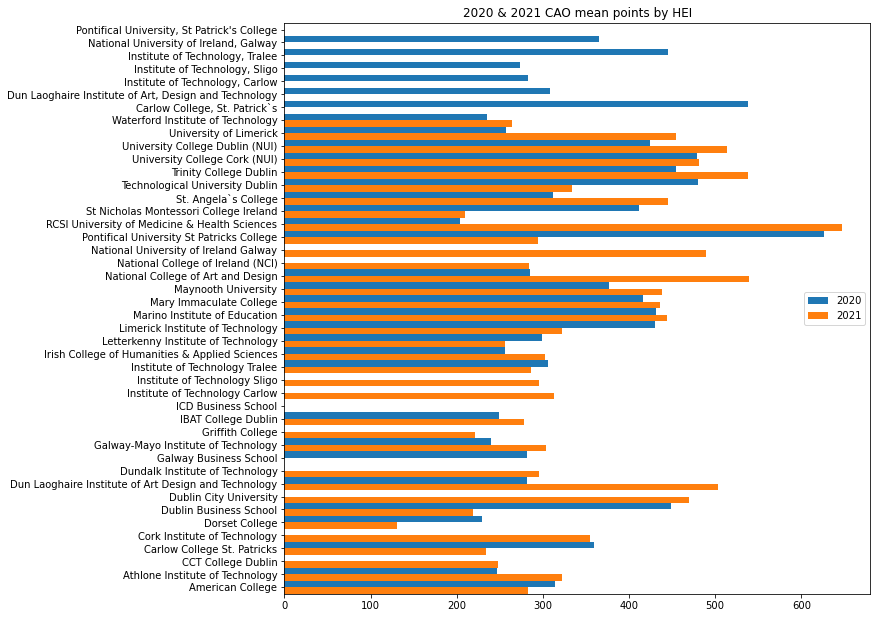

In [202]:
#get mean for each HEI per year
#return to individual year dfs
df2019 = all_Courses_Cols[all_Courses_Cols['Year']==2019]
df2020 = all_Courses_Cols[all_Courses_Cols['Year']==2020]
df2021 = all_Courses_Cols[all_Courses_Cols['Year']==2021]


#Group each year by HEI
df_groupby_HEI_2019 = df2019.groupby('HEI')
df_groupby_HEI_2020 = df2020.groupby('HEI')
df_groupby_HEI_2021 = df2021.groupby('HEI')

#Compare mean Round1 points 2020 and 2021 (No longer available for 2019)
df2020_mn=df_groupby_HEI_2020['R1'].mean()
df2021_mn=df_groupby_HEI_2021['R1'].mean()
#Reset indexes of groups dataframes easier to handle
df2020mnNew=df2020_mn.reset_index()
df2021mnNew=df2021_mn.reset_index()

#rename R1 columns and merge two dfs with outer join
df2020mnNew.rename(columns={'R1': 'R1_20'}, inplace=True)
df2021mnNew.rename(columns={'R1': 'R1_21'}, inplace=True)
df2020mnNew.set_index('HEI')
df2021mnNew.set_index('HEI')
#perform join
dfR1 = pd.merge(df2021mnNew,df2020mnNew,on='HEI', how='outer') #code adatpted from (Datacamp,2021)
#debug
#dfR1.to_csv('data/R1.csv')
#print(dfR1['R1_20'])


ind = np.arange(len(dfR1['HEI']))
width = 0.5

fig, ax = plt.subplots()
ax.barh(ind - width/2, dfR1['R1_20'], width,  label='2020')
ax.barh(ind + width/2, dfR1['R1_21'], width, label='2021')

plt.title("2020 & 2021 CAO mean points by HEI")
ax.set(yticks=ind + width, yticklabels=dfR1['HEI'], ylim=[2*width - 1, len(dfR1['HEI'])])
ax.legend()

plt.show()


RangeIndex(start=0, stop=37, step=1)


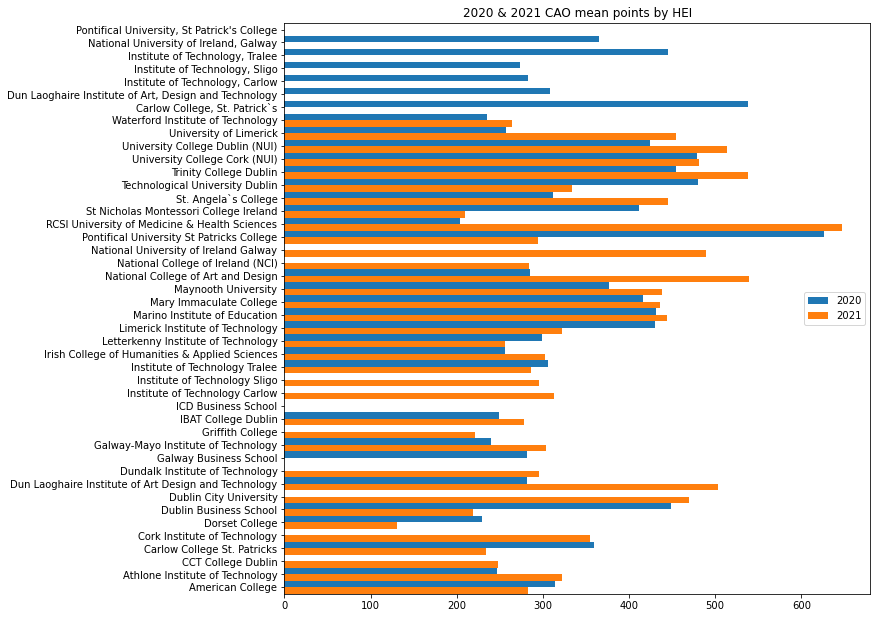

---
## References:

Camelot-py.readthedocs.io. 2021. Camelot: PDF Table Extraction for Humans — Camelot 0.10.1 documentation. [online] Available at: <https://camelot-py.readthedocs.io/en/master/> [Accessed 23 November 2021].

GitHub. 2021. Not able to read pdf tables spread across multiple pages · Issue #278 · atlanhq/camelot. [online] Available at: <https://github.com/atlanhq/camelot/issues/278> [Accessed 23 November 2021].

Hulsey, J. and Hulsey, J., 2021. How to iterate through a list of Data frames and drop all data if a specific string isnt found. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/55052989/how-to-iterate-through-a-list-of-data-frames-and-drop-all-data-if-a-specific-str> [Accessed 23 November 2021].

Medium. 2021. How To Create a New Column Based on Values From Other Columns in Pandas. [online] Available at: <https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d> [Accessed 23 November 2021].

Medium. 2021. Check For a Substring in a Pandas DataFrame Column. [online] Available at: <https://towardsdatascience.com/check-for-a-substring-in-a-pandas-dataframe-column-4b949f64852> [Accessed 23 November 2021].

Medium. 2022. Combining DataFrames using Pandas. [online] Available at: <https://towardsdatascience.com/combining-dataframes-using-pandas-b9e2e83b9869#:~:text=Another%20widely%20used%20function%20to,on%20values%20in%20shared%20columns.> [Accessed 2 January 2022].


Pandas.pydata.org. 2021. pandas.DataFrame — pandas 1.3.4 documentation. [online] Available at: <https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html> [Accessed 23 November 2021].
 
Pandas.pydata.org. 2021. pandas.read_excel — pandas 1.3.4 documentation. [online] Available at: <https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html?highlight=read_excel#pandas.read_excel> [Accessed 23 November 2021].

Pandas?, A., 2021. Appending to an empty DataFrame in Pandas?. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/16597265/appending-to-an-empty-dataframe-in-pandas> [Accessed 23 November 2021].
 
Docs.python.org. 2021. re — Regular expression operations — Python 3.10.0 documentation. [online] Available at: <https://docs.python.org/3/library/re.html> [Accessed 23 November 2021].
 
Stack Overflow. Available at: <https://stackoverflow.com/questions/15325182/how-to-filter-rows-in-pandas-by-regex/48884429> [Accessed 23 November 2021].
 
Docs.python-requests.org. 2021. Requests: HTTP for Humans™ — Requests 2.26.0 documentation. [online] Available at: <https://docs.python-requests.org/en/latest/index.html> [Accessed 23 November 2021].
 
R. and Prasanna, V., 2021. Right way to reindex a dataframe?. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/68261366/right-way-to-reindex-a-dataframe> [Accessed 23 November 2021].
 









## End